In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

### 1. Selección de Variables

In [184]:
X_train = pd.read_csv("preprocess_data/prep_Xtrain.csv")
X_test = pd.read_csv("preprocess_data/prep_Xtest.csv")

In [185]:
X_train.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0.961798,0.0,0.0,0.560191,0.125,0.166667,0.321798,0.0,0.333333
1,0.769663,0.5,1.0,0.308872,0.125,0.333333,0.081157,0.0,0.666667
2,0.106742,1.0,1.0,0.365578,0.000,0.000000,0.015713,0.0,0.333333
3,0.470787,1.0,0.0,0.120382,0.000,0.333333,0.047138,0.0,0.333333
4,0.233708,1.0,0.0,0.195778,0.000,0.000000,0.015127,0.0,1.000000


In [186]:
y_train = pd.read_csv("preprocess_data/prep_ytrain.csv")
y_test = pd.read_csv("preprocess_data/prep_ytest.csv")

y_train.head()

,Survived
0,1
1,0
2,0
3,0
4,1


In [187]:
np.isnan(X_train).any()

PassengerId    False
Pclass         False
Sex            False
Age            False
SibSp          False
Parch          False
Fare           False
Cabin          False
Embarked       False
dtype: bool

In [188]:
X_train['Cabin'].unique()

array([0.        , 0.42307692, 0.23076923, 0.61538462, 1.        ,
       0.69230769, 0.5       , 0.46153846, 0.92307692, 0.80769231,
       0.73076923, 0.96153846, 0.07692308, 0.38461538])

In [189]:
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
y_train.replace([np.inf, -np.inf], np.nan, inplace=True)

In [190]:
#objeto selector de variables
sel_ = SelectFromModel(Lasso(alpha=0.001, random_state=0))

sel_.fit(X_train, y_train)

SelectFromModel(estimator=Lasso(alpha=0.001, random_state=0))

In [191]:
sel_.get_support()

array([ True,  True,  True,  True,  True, False, False,  True,  True])

In [192]:
selected_features = X_train.columns[(sel_.get_support())]

In [193]:
selected_features

Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Cabin', 'Embarked'], dtype='object')

In [194]:
pd.Series(selected_features).to_csv('preprocess_data/selected_features.csv', index=False)

### 2. Entrenamiento del Modelo

In [195]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [196]:
linear_model = Lasso(alpha=0.001, random_state=2022)

linear_model.fit(X_train, y_train)

Lasso(alpha=0.001, random_state=2022)

#### 3. Predicciones

In [197]:
from sklearn.metrics import mean_squared_error, r2_score

In [198]:
preds_train = linear_model.predict(X_train)

In [199]:
#Train
print("MSE de Entrenamiento: {}".format(mean_squared_error(np.exp(y_train), np.exp(preds_train))))
print("RMSE de Entrenamiento: {}".format(mean_squared_error(np.exp(y_train), 
                                                           np.exp(preds_train), squared=False)))
print("R2 de Entrenamiento: {}".format(r2_score(np.exp(y_train), np.exp(preds_train))))

MSE de Entrenamiento: 0.4095870153394643
RMSE de Entrenamiento: 0.6399898556535598
R2 de Entrenamiento: 0.4130051834436458


In [200]:
preds_test = linear_model.predict(X_test)

In [201]:
#Test
print("MSE de Entrenamiento: {}".format(mean_squared_error(np.exp(y_test), np.exp(preds_test))))
print("RMSE de Entrenamiento: {}".format(mean_squared_error(np.exp(y_test), 
                                                           np.exp(preds_test), squared=False)))
print("R2 de Entrenamiento: {}".format(r2_score(np.exp(y_test), np.exp(preds_test))))

MSE de Entrenamiento: 0.5658438552207294
RMSE de Entrenamiento: 0.7522259336268123
R2 de Entrenamiento: 0.19295043049197702


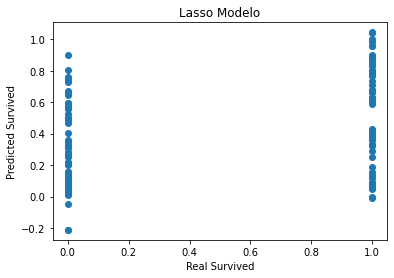

In [202]:
plt.scatter(y_test, preds_test)
plt.xlabel("Real Survived")
plt.ylabel("Predicted Survived")
plt.title("Lasso Modelo")
plt.show()

In [203]:
importance = pd.Series(np.abs(linear_model.coef_.ravel()))
importance.index = selected_features
importance.sort_values(inplace=True, ascending=False)

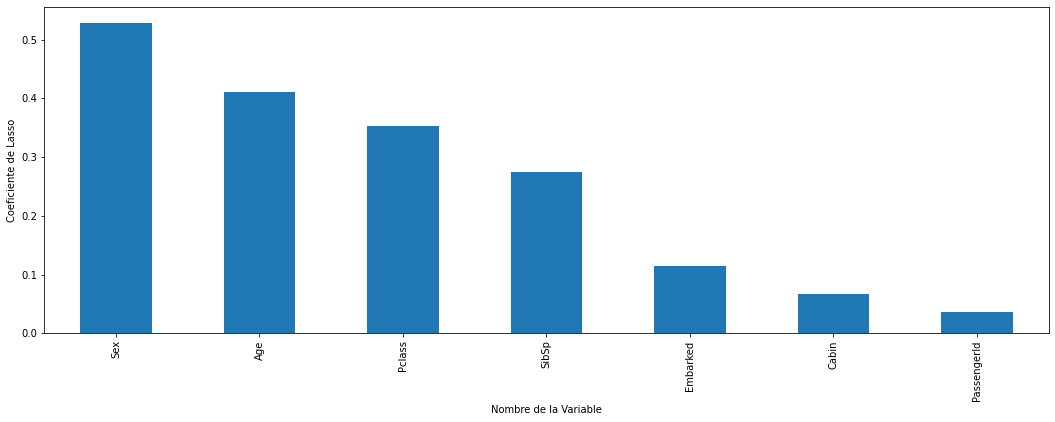

In [204]:
importance.plot.bar(figsize=(18, 6))
plt.ylabel("Coeficiente de Lasso")
plt.xlabel("Nombre de la Variable")
plt.show()

In [205]:
import joblib

In [207]:
joblib.dump(linear_model, 'final_model/lasso_reg.joblib')

['final_model/lasso_reg.joblib']

In [208]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Binarizer

from sklearn.pipeline import Pipeline

from feature_engine.imputation import(
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer
)

from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder
)

from feature_engine.transformation import LogTransformer

from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

import joblib

In [213]:
import my_preprocessors as mypp ##mi libreria

In [209]:
data = pd.read_csv("titanic.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [210]:
X_train, X_test, y_train, y_test = train_test_split(
        data.drop(['Survived'], axis=1),
        data['Survived'],
        test_size=0.1,
        random_state=2022)

X_train.shape, X_test.shape

((801, 11), (90, 11))

#### 4. Configuración del Machine Learning Pipeline

In [211]:
#Variable categoricas con NA pero indicador de Missing
CATEGORICAL_VARS_WITH_NA_MISSING = ['Cabin', 'Embarked']

#Variables numéricas con NA
NUMERICAL_VARS_WITH_NA = ['Age']

#Varaibles que vamos a tirar
DROP_FEATURES = ['Name','Ticket']

#Variables para hacer mapeo categorico por codificación ordinal
SEX_VAR = 'Sex'

EMBARKED_VAR = 'Embarked'

CABIN_VAR = 'Cabin'


#Mapeos de variables categoricas
SEX_VAR = {'female':1, 'male':2,'NA':0, 'NaN':0}

EMBARKED_VAR = {'S':1, 'C':2, 'Q':3,'NA':0,'NaN':0,'Missing':0}

CABIN_VAR = {'A31':1, 'B28':2, 'B38':3, 'B79':4, 'C104':5, 'C2':6, 'C30':7,'C49':8,'C50':9,'C78':10,'C83':11, 'C92':12, 'C93':13, 'D21':14, 'D30':15, 'D33':16, 'D56':17, 'E101':18, 'E24':19, 'E31':20,'E33':21, 'E49':22, 'F G63':23, 'F G73':24, 'F33':25, 'G6':26, 'Missing':0, 'NA':0, 'NaN':0, ' ':0}


#Variables seleccionadas según análisis de Lasso
FEATURES = ['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Cabin', 'Embarked']

In [212]:
housePrice_pipeline = Pipeline([
    
    #============= IMPUTACIONES ===================#
    
    #1. Imputación de varaibles categoricas
    ('missing_imputation', 
         CategoricalImputer(imputation_method='missing', variables=CATEGORICAL_VARS_WITH_NA_MISSING)
    ),
         
    #2. Indicamos Faltante en variables numéricas para imputar
    ('missing_indicator', AddMissingIndicator(variables=NUMERICAL_VARS_WITH_NA)),
        
]) 